# Introductory Tutorial

## Tutorial Description

[Mesa](https://github.com/projectmesa/mesa) is a Python framework for [agent-based modeling](https://en.wikipedia.org/wiki/Agent-based_model).  Getting started with Mesa is easy. In this tutorial, we will walk through creating a simple model and progressively add functionality which will illustrate Mesa's core features.

**Note:** This tutorial is a work-in-progress. If you find any errors or bugs, or just find something unclear or confusing, [let us know](https://github.com/projectmesa/mesa/issues)!

The base for this tutorial is a very simple model of agents exchanging money. Next, we add *space* to allow agents to move. Then, we'll cover two of Mesa's analytic tools: the *data collector* and *batch runner*. After that, we'll add an *interactive visualization* which lets us watch the model as it runs. Finally, we go over how to write your own visualization module, for users who are comfortable with JavaScript.

You can also find all the code this tutorial describes in the **examples/boltzmann_wealth_model** directory of the Mesa repository.

## Sample Model Description

The tutorial model is a very simple simulated agent-based economy, drawn from econophysics and presenting a statistical mechanics approach to wealth distribution [Dragulescu2002]. The rules of our tutorial model:

1. There are some number of agents.
2. All agents begin with 1 unit of money.
3. At every step of the model, an agent gives 1 unit of money (if they have it) to some other agent.

Despite its simplicity, this model yields results that are often unexpected to those not familiar with it. For our purposes, it also easily demonstrates Mesa's core features.

We import these libraries here to use in the tutorial.

In [1]:
# Imports
import mesa
import pandas as pd
import numpy as np
import seaborn as sns

# Set the default figure size for all seaborn plots throughout the tutorial
sns.set(rc={"figure.figsize": (6, 3)})

Let's get started.

### Installation

To start, install Mesa. We recommend doing this in a [virtual environment](https://virtualenvwrapper.readthedocs.org/en/stable/), but make sure your environment is set up with Python 3. Mesa requires Python3 and does not work in Python 2 environments.

To install Mesa, simply:

```bash
    $ pip install --upgrade mesa
```

When you do that, it will install Mesa itself, as well as any dependencies that aren't in your setup yet. Additional dependencies required by this tutorial can be found in the **examples/boltzmann_wealth_model/requirements.txt** file, which can be installed directly form the github repository by running:

```bash
    $ pip install --upgrade -r https://github.com/projectmesa/mesa-examples/blob/main/examples/boltzmann_wealth_model_network/requirements.txt
```

This will install the dependencies listed in the requirements.txt file which are:  
- mesa (this ABM library -- if not installed)
- jupyter (Ipython interactive notebook)
- matplotlib (Python's visualization library)
- seaborn (high-level visualization library)
- numpy (Python's numerical python library)
- pandas (Data analysis and manipulation library)

## Building a sample model

Once Mesa is installed, you can start building our model. You can write models in two different ways:

1. Write the code in its own file with your favorite text editor, or
2. Write the model interactively in [Jupyter Notebook](http://jupyter.org/) cells.

Either way, it's good practice to put your model in its own folder -- especially if the project will end up consisting of multiple files (for example, Python files for the model and the visualization, a Notebook for analysis, and a Readme with some documentation and discussion).

Begin by creating a folder, and either launch a Notebook or create a new Python source file.  We will use the name `money_model.py` here.



### Setting up the model

To begin writing the model code, we start with two core classes: one for the overall model, the other for the agents. The model class holds the model-level attributes, manages the agents, and generally handles the global level of our model. Each instantiation of the model class will be a specific model run. Each model will contain multiple agents, all of which are instantiations of the agent class. Both the model and agent classes are child classes of Mesa's generic `Model` and `Agent` classes. This is seen in the code with `class MoneyModel(mesa.Model)` or `class MoneyAgent(mesa.Agent)`. If you want you can specifically the class being imported by looking at the [model](https://github.com/projectmesa/mesa/blob/main/mesa/model.py) or [agent](https://github.com/projectmesa/mesa/blob/main/mesa/agent.py) code in the mesa repo.

Each agent has only one variable: how much wealth it currently has. (Each agent will also have a unique identifier (i.e., a name), stored in the `unique_id` variable. Giving each agent a unique id is a good practice when doing agent-based modeling.)

There is only one model-level parameter: how many agents the model contains. When a new model is started, we want it to populate itself with the given number of agents.

The beginning of both classes looks like this:

In [2]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

### Adding the scheduler

Time in most agent-based models moves in steps, sometimes also called **ticks**. At each step of the model, one or more of the agents -- usually all of them -- are activated and take their own step, changing internally and/or interacting with one another or the environment.

The **scheduler** is a special model component which controls the order in which agents are activated. For example, all the agents may activate in the same order every step; their order might be shuffled; we may try to simulate all the agents acting at the same time; and more. Mesa offers a few different built-in scheduler classes, with a common interface. That makes it easy to change the activation regime a given model uses, and see whether it changes the model behavior. This may not seem important, but scheduling patterns can have an impact on your results [Comer2014].

For now, let's use one of the simplest ones: `RandomActivation`*, which activates all the agents once per step, in random order. Every agent is expected to have a ``step`` method. The step method is the action the agent takes when it is activated by the model schedule. We add an agent to the schedule using the `add` method; when we call the schedule's `step` method, the model shuffles the order of the agents, then activates and executes each agent's ```step``` method.

*Unlike `mesa.model` or `mesa.agent`, `mesa.time` has multiple classes (e.g. `RandomActivation`, `StagedActivation` etc). To ensure context, time is used in the import as evidenced below with `mesa.time.Randomactivation`.  You can see the different time classes as [mesa.time](https://github.com/projectmesa/mesa/blob/main/mesa/time.py). 

With that in mind, the model code with the scheduler added looks like this:

In [3]:
import mesa


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Hi, I am agent " + str(self.unique_id) + ".")


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step()

At this point, we have a model which runs -- it just doesn't do anything. You can see for yourself with a few easy lines. If you've been working in an interactive session, you can create a model object directly. Otherwise, you need to open an interactive session in the same directory as your source code file, and import the classes. For example, if your code is in `money_model.py`:

```python
from money_model import MoneyModel
```
Then create the model object, and run it for one step:

In [4]:
empty_model = MoneyModel(10)
empty_model.step()

Hi, I am agent 9.
Hi, I am agent 3.
Hi, I am agent 5.
Hi, I am agent 1.
Hi, I am agent 7.
Hi, I am agent 6.
Hi, I am agent 0.
Hi, I am agent 2.
Hi, I am agent 4.
Hi, I am agent 8.


#### Exercise
    
Try modifying the code above to have every agent print out its `wealth` when it is activated. Run a few steps of the model to see how the agent activation order is shuffled each step.

### Agent Step

Now we just need to have the agents do what we intend for them to do: check their wealth, and if they have the money, give one unit of it away to another random agent. To allow the agent to choose another agent at random, we use the ``model.random`` random-number generator. This works just like Python's ``random`` module, but with a fixed seed set when the model is instantiated, that can be used to replicate a specific model run later.

To pick an agent at random, we need a list of all agents. Notice that there isn't such a list explicitly in the model. The scheduler, however, does have an internal list of all the agents it is scheduled to activate.

With that in mind, we rewrite the agent `step` method, like this:

In [5]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

### Running your first model

With that last piece in hand, it's time for the first rudimentary run of the model.

If you've written the code in its own file (`money_model.py` or a different name), launch an interpreter in the same directory as the file (either the plain Python command-line interpreter, or the IPython interpreter), or launch a Jupyter Notebook there. Then import the classes you created. (If you wrote the code in a Notebook, obviously this step isn't necessary).

```python
from money_model import *
```

Now let's create a model with 10 agents, and run it for 10 steps.

In [6]:
model = MoneyModel(10)
for i in range(10):
    model.step()

Next, we need to get some data out of the model. Specifically, we want to see the distribution of the agent's wealth. We can get the wealth values with list comprehension, and then use matplotlib (or another graphics library) to visualize the data in a histogram.

If you are running from a text editor or IDE, you'll also need to add this line, to make the graph appear.

```python
plt.show()
```

[0, 0, 2, 1, 1, 0, 0, 0, 0, 6]


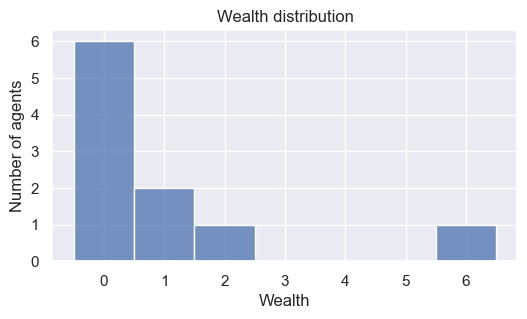

In [7]:
# Create a list of agent wealth
agent_wealth = [a.wealth for a in model.schedule.agents]
print(agent_wealth)

# Create a histogram with seaborn
g = sns.histplot(agent_wealth, discrete=True)
g.set(
    title="Wealth distribution", xlabel="Wealth", ylabel="Number of agents"
);  # The semicolon is just to avoid printing the object representation

You'll should see something like the distribution above. Yours will almost certainly look at least slightly different, since each run of the model is random, after all.

To get a better idea of how a model behaves, we can create multiple model runs and see the distribution that emerges from all of them. We can do this with a nested for loop:

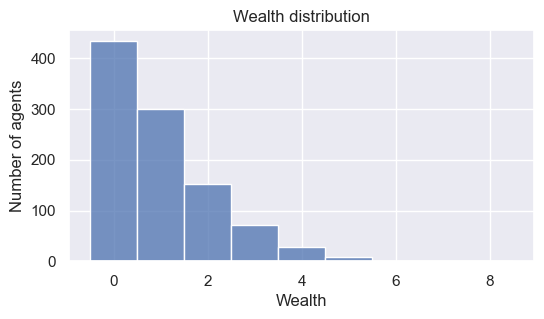

In [8]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

# Use seaborn
g = sns.histplot(all_wealth, discrete=True)
g.set(title="Wealth distribution", xlabel="Wealth", ylabel="Number of agents");

This runs 100 instantiations of the model, and runs each for 10 steps. (Notice that we set the histogram bins to be integers, since agents can only have whole numbers of wealth). This distribution looks a lot smoother. By running the model 100 times, we smooth out some of the 'noise' of randomness, and get to the model's overall expected behavior.

This outcome might be surprising. Despite the fact that all agents, on average, give and receive one unit of money every step, the model converges to a state where most agents have a small amount of money and a small number have a lot of money.

### Adding space

Many ABMs have a spatial element, with agents moving around and interacting with nearby neighbors. Mesa currently supports two overall kinds of spaces: grid, and continuous. Grids are divided into cells, and agents can only be on a particular cell, like pieces on a chess board. Continuous space, in contrast, allows agents to have any arbitrary position. Both grids and continuous spaces are frequently [toroidal](https://en.wikipedia.org/wiki/Toroidal_graph), meaning that the edges wrap around, with cells on the right edge connected to those on the left edge, and the top to the bottom. This prevents some cells having fewer neighbors than others, or agents being able to go off the edge of the environment.

Let's add a simple spatial element to our model by putting our agents on a grid and make them walk around at random. Instead of giving their unit of money to any random agent, they'll give it to an agent on the same cell.

Mesa has two main types of grids: `SingleGrid` and `MultiGrid`*. `SingleGrid` enforces at most one agent per cell; `MultiGrid` allows multiple agents to be in the same cell. Since we want agents to be able to share a cell, we use `MultiGrid`.

*However there are more types of space to include `HexGrid`, `NetworkGrid`, and the previously mentioned `ContinuousSpace`. Similar to `mesa.time` context is retained with `mesa.space.[enter class]`. You can see the different classes as [mesa.space](https://github.com/projectmesa/mesa/blob/main/mesa/space.py) 

We instantiate a grid with width and height parameters, and a boolean as to whether the grid is toroidal. Let's make width and height model parameters, in addition to the number of agents, and have the grid always be toroidal. We can place agents on a grid with the grid's `place_agent` method, which takes an agent and an (x, y) tuple of the coordinates to place the agent.

In [9]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

Under the hood, each agent's position is stored in two ways: the agent is contained in the grid in the cell it is currently in, and the agent has a `pos` variable with an (x, y) coordinate tuple. The `place_agent` method adds the coordinate to the agent automatically.

Now we need to add to the agents' behaviors, letting them move around and only give money to other agents in the same cell.

First let's handle movement, and have the agents move to a neighboring cell. The grid object provides a `move_agent` method, which like you'd imagine, moves an agent to a given cell. That still leaves us to get the possible neighboring cells to move to. There are a couple ways to do this. One is to use the current coordinates, and loop over all coordinates +/- 1 away from it. For example:

```python
neighbors = []
x, y = self.pos
for dx in [-1, 0, 1]:
    for dy in [-1, 0, 1]:
        neighbors.append((x+dx, y+dy))
```

But there's an even simpler way, using the grid's built-in `get_neighborhood` method, which returns all the neighbors of a given cell. This method can get two types of cell neighborhoods: [Moore](https://en.wikipedia.org/wiki/Moore_neighborhood) (includes all 8 surrounding squares), and [Von Neumann](https://en.wikipedia.org/wiki/Von_Neumann_neighborhood)(only up/down/left/right). It also needs an argument as to whether to include the center cell itself as one of the neighbors.

With that in mind, the agent's `move` method looks like this:

```python
class MoneyAgent(mesa.Agent):
   #...
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
```

Next, we need to get all the other agents present in a cell, and give one of them some money. We can get the contents of one or more cells using the grid's `get_cell_list_contents` method, or by accessing a cell directly. The method accepts a list of cell coordinate tuples, or a single tuple if we only care about one cell.

```python
class MoneyAgent(mesa.Agent):
    #...
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
```

And with those two methods, the agent's ``step`` method becomes:

```python
class MoneyAgent(mesa.Agent):
    # ...
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
```

Now, putting that all together should look like this:

In [10]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

Let's create a model with 100 agents on a 10x10 grid, and run it for 20 steps.

In [11]:
model = MoneyModel(100, 10, 10)
for i in range(20):
    model.step()

Now let's use matplotlib and numpy to visualize the number of agents residing in each cell. To do that, we create a numpy array of the same size as the grid, filled with zeros. Then we use the grid object's `coord_iter()` feature, which lets us loop over every cell in the grid, giving us each cell's coordinates and contents in turn.

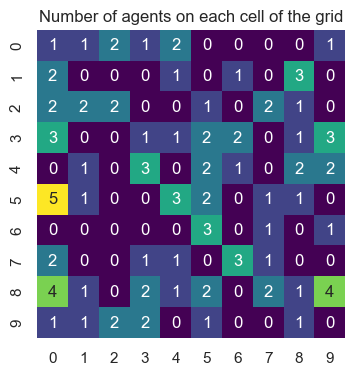

In [12]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count

# Same plot using seaborn, size 5 by 5
g = sns.heatmap(agent_counts, cmap="viridis", annot=True, cbar=False, square=True)
g.figure.set_size_inches(4, 4)
g.set(title="Number of agents on each cell of the grid");

### Collecting Data

So far, at the end of every model run, we've had to go and write our own code to get the data out of the model. This has two problems: it isn't very efficient, and it only gives us end results. If we wanted to know the wealth of each agent at each step, we'd have to add that to the loop of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data: model-level variables, agent-level variables, and tables (which are a catch-all for everything else). Model- and agent-level variables are added to the data collector along with a function for collecting them. Model-level collection functions take a model object as an input, while agent-level collection functions take an agent object as an input. Both then return a value computed from the model or each agent at their current state. When the data collector’s `collect` method is called, with a model object as its argument, it applies each model-level collection function to the model, and stores the results in a dictionary, associating the current value with the current step of the model. Similarly, the method applies each agent-level collection function to each agent currently in the schedule, associating the resulting value with the step of the model, and the agent’s `unique_id`.

Let's add a DataCollector to the model with [`mesa.DataCollector`](https://github.com/projectmesa/mesa/blob/main/mesa/datacollection.py), and collect two variables. At the agent level, we want to collect every agent's wealth at every step. At the model level, let's measure the model's [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), a measure of wealth inequality.

In [13]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # Create a DataCollector to collect model-level and agent-level data
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

    def step(self):
        """Advance the model by one step."""
        # Before we step, collect data
        self.datacollector.collect(self)
        self.schedule.step()

At every step of the model, the datacollector will collect and store the model-level current Gini coefficient, as well as each agent's wealth, associating each with the current step.

We run the model just as we did above. Now is when an interactive session, especially via a Notebook, comes in handy: the DataCollector can export the data its collected as a pandas\* DataFrame, for easy interactive analysis. 

\*If you are new to Python, please be aware that pandas is already installed as a dependency of Mesa and that [pandas](https://pandas.pydata.org/docs/) is a "fast, powerful, flexible and easy to use open source data analysis and manipulation tool". pandas is great resource to help analyze the data collected in your models 

In [14]:
model = MoneyModel(50, 10, 10)
for i in range(100):
    model.step()

To get the series of Gini coefficients as a pandas DataFrame:

In [15]:
gini = model.datacollector.get_model_vars_dataframe()
gini.head(3)

,Gini
Step,
0,0.0000
1,0.2112
2,0.3512


Similarly, we can get the agent-wealth data:

In [16]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head(3)

Wealth
Step AgentID        
0    0             1
     1             1
     2             1

Note that the DataFrame has a multi-level index, with the first level being the step number, and the second level being the agent ID. This is because the data collector stores the data in a dictionary, with the step number as the key, and a dictionary of agent ID and variable value pairs as the value. The data collector then converts this dictionary into a DataFrame, which is why the index is a multi-level index.

#### Selecting and visualizing the data

A simple visualization of the Gini coefficient over time:

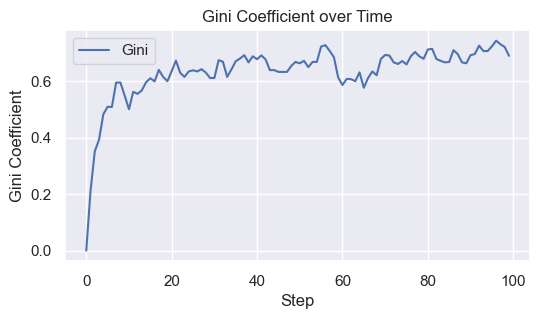

In [17]:
# Plot the Gini coefficient over time
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

You'll see that the DataFrame's index is pairings of model step and agent ID. You can analyze it the way you would any other DataFrame. For example, to get a histogram of agent wealth at the model's end:

In [18]:
# Get the last step
last_step = agent_wealth.index.get_level_values("Step").max()
print(f"Last step: {last_step}")

# Create a Pandas Series of the wealth at the last step
end_wealth = agent_wealth.xs(last_step, level="Step")["Wealth"]
end_wealth.head(3)

Last step: 99


AgentID
0    0
1    0
2    2
Name: Wealth, dtype: int64

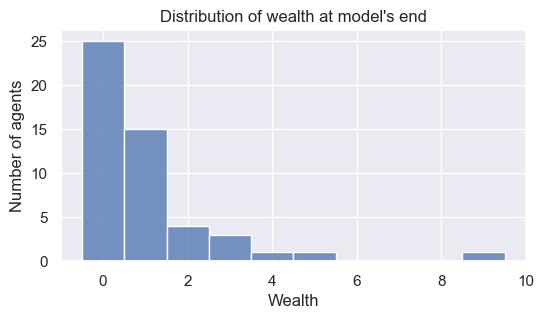

In [19]:
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at model's end",
    xlabel="Wealth",
    ylabel="Number of agents",
);

Or to plot the wealth of a given agent (in this example, agent 14):

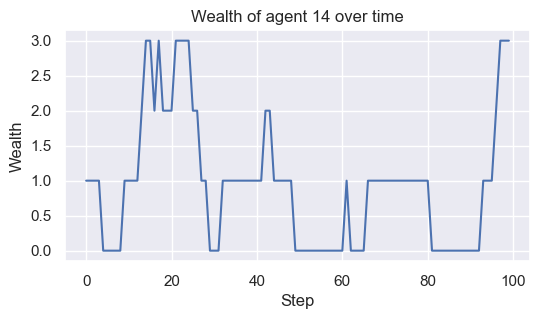

In [20]:
# Get the wealth of agent 14 over time
one_agent_wealth = agent_wealth.xs(14, level="AgentID")

# Plot the wealth of agent 14 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 14 over time");

 You can also plot a reporter of multiple agents over time.

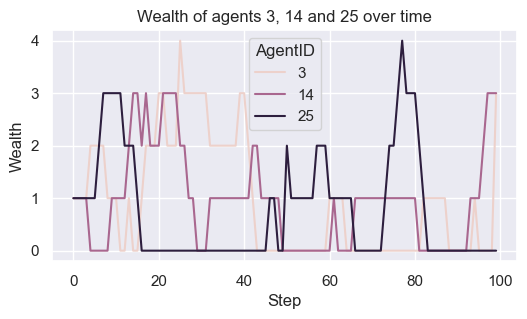

In [21]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]

# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

We can also plot the average of all agents, with a 95% confidence interval for that average.

In [22]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

,Step,AgentID,Variable,Value
0,0,0,Wealth,1
1,0,1,Wealth,1
2,0,2,Wealth,1


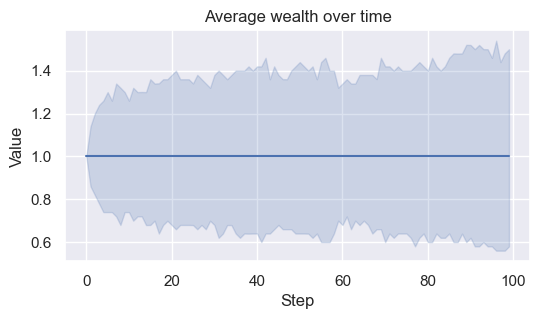

In [23]:
# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time");

Which is exactly 1, as expected in this model, since each agent starts with one wealth unit, and each agent gives one wealth unit to another agent at each step.

#### Saving data

You can also use pandas to export the data to a CSV (comma separated value), which can be opened by any common spreadsheet application or opened by pandas.

If you do not specify a file path, the file will be saved in the local directory. After you run the code below you will see two files appear (*model_data.csv* and *agent_data.csv*)

In [24]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

We can read the model again, using:

In [25]:
# Read the model data from the CSV file
gini = pd.read_csv("model_data.csv", index_col=0)
gini.head(3)

,Gini
Step,
0,0.0000
1,0.2112
2,0.3512


This is especially useful with models that run for a long time, as it allows you to save the data and then analyze it later, without having to re-run the model.

### Batch Run

Like we mentioned above, you usually won't run a model only once, but multiple times, with fixed parameters to find the overall distributions the model generates, and with varying parameters to analyze how they drive the model's outputs and behaviors. Instead of needing to write nested for-loops for each model, Mesa provides a [`batch_run`](https://github.com/projectmesa/mesa/blob/main/mesa/batchrunner.py) function which automates it for you.

The batch runner also requires an additional variable `self.running` for the MoneyModel class. This variable enables conditional shut off of the model once a condition is met. In this example it will be set as True indefinitely.

#### Additional agent reporter

To make the results a little bit more interesting, we will also calculate the number of consecutive time steps an agent hasn't given any wealth as an agent reporter.

This way we can see how data is handled when multiple reporters are used.

In [26]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum(xi * (N - i) for i, xi in enumerate(x)) / (N * sum(x))
    return 1 + (1 / N) - 2 * B


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"},
        )

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
        else:
            self.steps_not_given += 1

#### Batch Run

We call `batch_run` with the following arguments:

* `model_cls`
  The model class that is used for the batch run.
* `parameters`
  A dictionary containing all the parameters of the model class and desired values to use for the batch run as key-value pairs. Each value can either be fixed ( e.g. `{"height": 10, "width": 10}`) or an iterable (e.g. `{"N": range(10, 500, 10)}`). `batch_run` will then generate all possible parameter combinations based on this dictionary and run the model `iterations` times for each combination.
* `number_processes`
  If not specified, defaults to 1. Set it to `None` to use all the available processors.
  Note: Multiprocessing does make debugging challenging. If your parameter sweeps are resulting in unexpected errors set `number_processes=1`.
* `iterations`
  The number of iterations to run each parameter combination for. Optional. If not specified, defaults to 1.
* `data_collection_period`
  The length of the period (number of steps) after which the model and agent reporters collect data. Optional. If not specified, defaults to -1, i.e. only at the end of each episode.
* `max_steps`
  The maximum number of time steps after which the model halts. An episode does either end when `self.running` of the model class is set to `False` or when `model.schedule.steps == max_steps` is reached. Optional. If not specified, defaults to 1000.
* `display_progress`
  Display the batch run progress. Optional. If not specified, defaults to `True`.

In the following example, we hold the height and width fixed, and vary the number of agents. We tell the batch runner to run 5 instantiations of the model with each number of agents, and to run each for 100 steps. 

We want to keep track of

1. the Gini coefficient value at each time step, and
2. the individual agent's wealth development and steps without giving money.

**Important:** Since for the latter changes at each time step might be interesting, we set `data_collection_period=1`. By default, it only collects data at the end of each episode.

Note: The total number of runs is 245 (= 49 different populations * 5 iterations per population). However, the resulting list of dictionaries will be of length 6186250 (= 250 average agents per population * 49 different populations * 5 iterations per population * 101 steps per iteration). 

**Note for Windows OS users:** If you are running this tutorial in Jupyter, make sure that you set `number_processes = 1` (single process). If `number_processes` is greater than 1, it is less straightforward to set up. You can read [Mesa's collection of useful snippets](https://github.com/projectmesa/mesa/blob/main/docs/useful-snippets/snippets.rst), in 'Using multi-process `batch_run` on Windows' section for how to do it.

In [27]:
params = {"width": 10, "height": 10, "N": range(10, 500, 10)}

results = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,
    max_steps=100,
    number_processes=1,
    data_collection_period=1,  # Important, otherwise the datacollector will only collect data of the last time step
    display_progress=True,
)

100%|██████████| 245/245 [00:18<00:00, 13.59it/s]


To further analyze the return of the `batch_run` function, we convert the list of dictionaries to a Pandas DataFrame and print its keys.

In [28]:
# Convert results dictionary to a Pandas DataFrame
results_df = pd.DataFrame(results)
print(f"Column names in the dataframe: {results_df.columns.tolist()}")
results_df.head()

Column names in the dataframe: ['RunId', 'iteration', 'Step', 'width', 'height', 'N', 'Gini', 'AgentID', 'Wealth', 'Steps_not_given']


,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth,Steps_not_given
0,0,0,0,10,10,10,0.0,0,1,0
1,0,0,0,10,10,10,0.0,1,1,0
2,0,0,0,10,10,10,0.0,2,1,0
3,0,0,0,10,10,10,0.0,3,1,0
4,0,0,0,10,10,10,0.0,4,1,0


#### Analyzing model reporters

First, we want to take a closer look at how the Gini coefficient at the end of each episode changes as we increase the size of the population. For this, we filter our results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode and then scatter-plot the values for the Gini coefficient over the the number of agents. Notice there are five values for each population size since we set `iterations=5` when calling the batch run.

In [29]:
# Filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time) at the 100th step of each episode
results_filtered = results_df[(results_df.AgentID == 0) & (results_df.Step == 100)]
results_filtered[["iteration", "N", "Gini"]].reset_index(drop=True).head()

,iteration,N,Gini
0,0,10,0.64000
1,0,20,0.63500
2,0,30,0.68000
3,0,40,0.72125
4,0,50,0.62000


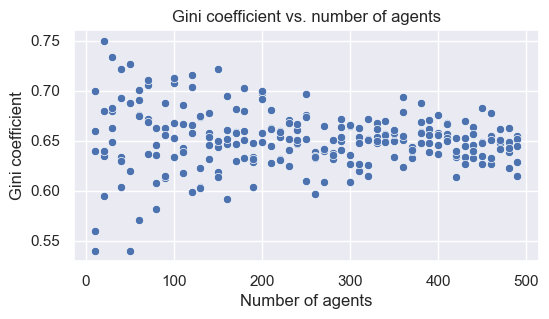

In [30]:
# Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="N", y="Gini")
g.set(
    xlabel="Number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

We can create differnt kinds of plot from this filtered DataFrame. For example, a point plot with error bars.

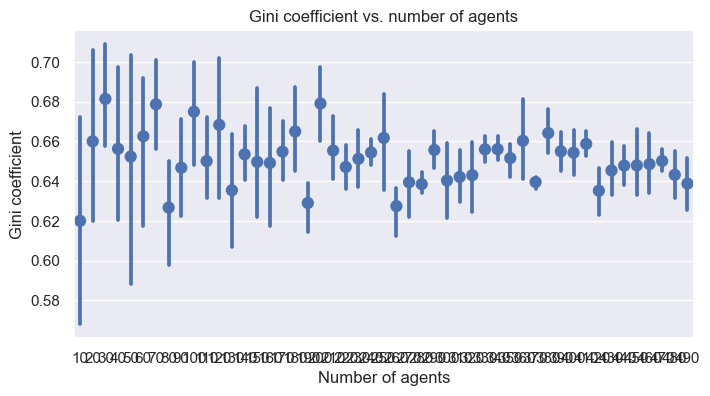

In [31]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x="N", y="Gini", join=False)
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="Number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

#### Analyzing model reporters: Comparing 5 scenarios

Other insight might be gathered when we compare the Gini coefficient of different scenarios. For example, we can compare the Gini coefficient of a population with 25 agents to the Gini coefficient of a population with 400 agents. While doing this, we increase the number of iterations to 25 to get a better estimate of the Gini coefficient for each population size and get usable error estimations.

In [32]:
params = {"width": 10, "height": 10, "N": [5, 10, 20, 40, 80]}

results_5s = mesa.batch_run(
    MoneyModel,
    parameters=params,
    iterations=100,
    max_steps=120,
    number_processes=1,
    data_collection_period=1,  # Important, otherwise the datacollector will only collect data of the last time step
    display_progress=True,
)

results_5s_df = pd.DataFrame(results_5s)

100%|██████████| 500/500 [00:05<00:00, 87.22it/s]


In [33]:
# Again filter the results to only contain the data of one agent (the Gini coefficient will be the same for the entire population at any time)
results_5s_df_filtered = results_5s_df[(results_5s_df.AgentID == 0)]
results_5s_df_filtered.head(3)

,RunId,iteration,Step,width,height,N,Gini,AgentID,Wealth,Steps_not_given
0,0,0,0,10,10,5,0.0,0,1,0
5,0,0,1,10,10,5,0.0,0,1,1
10,0,0,2,10,10,5,0.0,0,1,2


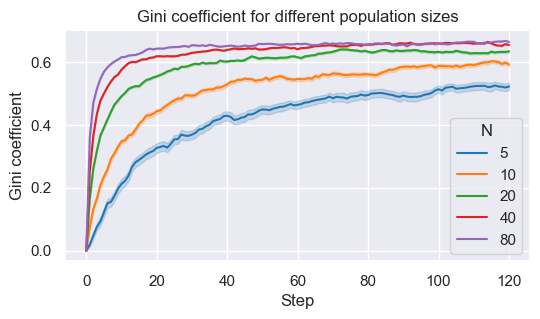

In [34]:
# Create a lineplot with error bars
g = sns.lineplot(
    data=results_5s_df,
    x="Step",
    y="Gini",
    hue="N",
    errorbar=("ci", 95),
    palette="tab10",
)
g.set(
    title="Gini coefficient for different population sizes", ylabel="Gini coefficient"
);

In this case it looks like the Gini coefficient increases slower for smaller populations. This can be because of different things, either because the Gini coefficient is a measure of inequality and the smaller the population, the more likely it is that the agents are all in the same wealth class, or because there are less interactions between agents in smaller populations, which means that the wealth of an agent is less likely to change.

#### Analyzing agent reporters

From the agents we collected the wealth and the number of consecutive rounds without a transaction. We can compare the 5 different population sizes by plotting the average number of consecutive rounds without a transaction for each population size.

Note that we're aggregating multiple times here: First we take the average of all agents for each single replication. Then we plot the averages for all replications, with the error band showing the 95% confidence interval of that first average (over all agents). So this error band is representing the uncertainty of the _mean_ value of the number of consecutive rounds without a transaction for each population size.

In [35]:
# Calculate the mean of the wealth and the number of consecutive rounds for all agents in each episode
agg_results_df = (
    results_5s_df.groupby(["iteration", "N", "Step"])
    .agg({"Wealth": "mean", "Steps_not_given": "mean"})
    .reset_index()
)
agg_results_df.head(3)

,iteration,N,Step,Wealth,Steps_not_given
0,0,5,0,1.0,0.0
1,0,5,1,1.0,1.0
2,0,5,2,1.0,2.0


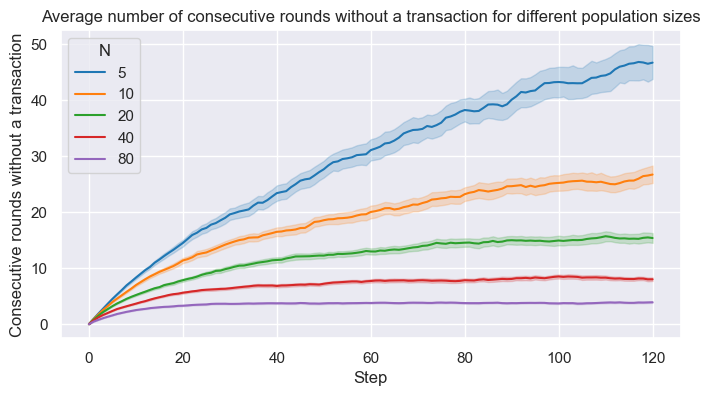

In [36]:
# Create a scatter plot
g = sns.lineplot(
    data=agg_results_df, x="Step", y="Steps_not_given", hue="N", palette="tab10"
)
g.figure.set_size_inches(8, 4)
g.set(
    title="Average number of consecutive rounds without a transaction for different population sizes",
    ylabel="Consecutive rounds without a transaction",
);

It can be clearly seen that the lower the number of agents, the higher the number of consecutive rounds without a transaction. This is because the agents have less interactions with each other and therefore the wealth of an agent is less likely to change.

#### General steps for analyzing results

Many other analysis are possible based on the policies, scenarios and uncertainties that you might be interested in. In general, you can follow these steps to do your own analysis:

1. Determine which metrics you want to analyse. Add these as model and agent reporters to the datacollector of your model.
2. Determine the input parameters you want to vary. Add these as parameters to the batch_run function, using ranges or lists to test different values.
3. Determine the hyperparameters of the batch_run function. Define the number of iterations, the number of processes, the number of steps, the data collection period, etc.
4. Run the batch_run function and save the results.
5. Transform, filter and aggregate the results to get the data you want to analyze. Make sure it's in long format, so that each row represents a single value.
6. Choose a plot type, what to plot on the x and y axis, which columns to use for the hue. Seaborn also has an amazing [Example Gallery](https://seaborn.pydata.org/examples/index.html).
7. Plot the data and analyze the results.

### Happy Modeling!

This document is a work in progress. If you see any errors, exclusions or have any problems please contact [us](https://github.com/projectmesa/mesa/issues).

`virtual environment`: http://docs.python-guide.org/en/latest/dev/virtualenvs/

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.